In [20]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad
import sklearn
import scipy

import matplotlib.pyplot as plt

import skeleton_methods.skeleton as skel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph

import random
 
random.seed(123)

adata2000 = scv.read('data/pancreasd2000.h5ad')

In [2]:
X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]

subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]

In [3]:
import pickle
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

# Using Laplacian Eigenmap for smoothing

In [4]:
from sklearn.manifold import SpectralEmbedding
LEembedding = SpectralEmbedding(n_components=100)

X_LE = LEembedding.fit_transform(X)


In [6]:
velocity = V

knots = skeleton_r["centers"]
voron_weights = skeleton_r["voron_weights"]

from collections import defaultdict
idxSet = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    idxSet[i] = skeleton_r["cluster"] == i

knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)

knot_X = np.array([[0.0 for _ in  range(X.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_X[i,:] = np.mean(X[idxSet[i],:], axis = 0)


In [22]:
# extending eigenmap to out-of-sample points takes a bit more work, so manually compute eigenmap first
from scipy.linalg import eigh
adjacency = LEembedding.affinity_matrix_
adjacency = sklearn.utils.validation.check_symmetric(adjacency)
n_nodes = adjacency.shape[0]

laplacian, dd = scipy.sparse.csgraph.laplacian(adjacency, normed=True, return_diag=True)
laplacian = sklearn.utils.check_array(laplacian, dtype=np.float64, accept_sparse=True)

if scipy.sparse.isspmatrix(laplacian):
    laplacian = laplacian.toarray()


In [23]:
lambdas, diffusion_map = eigh(laplacian)

In [32]:
diffusion_map.shape

(3696, 3696)

In [33]:
n_components = 100
embedding = diffusion_map.T[:n_components] * dd
embedding = sklearn.utils.extmath._deterministic_vector_sign_flip(embedding)
embedding = embedding.T

In [34]:
embedding.shape

(3696, 100)

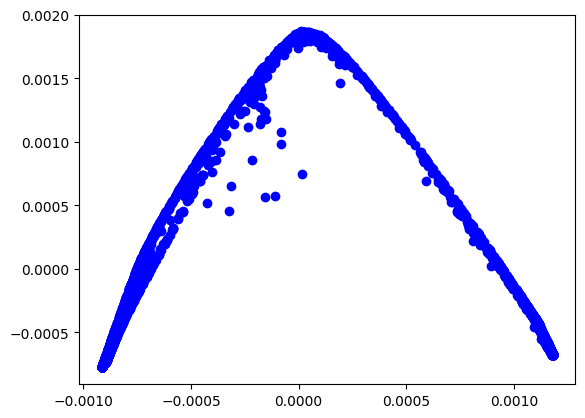

In [36]:
plt.scatter(X_LE[:,0], X_LE[:,1], c ="blue")
 
# To show the plot
plt.show()

In [30]:
# maybe easier to just take the average of the embedded points
knot_XLE = np.array([[0.0 for _ in  range(X_LE.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_XLE[i,:] = np.mean(X_LE[idxSet[i],:], axis = 0)

In [31]:
from numpy.linalg import norm
knot_velocity_graph_direct0 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if i != j and voron_weights[i,j] > 0:
            xdiff = knot_XLE[j,:]-  knot_XLE[i,:]
            knot_velocity_graph_direct0[i,j] = np.dot(knot_velocity[i,:], xdiff)/(norm(xdiff)*norm(knot_velocity[i,:]))

ValueError: shapes (1027,) and (100,) not aligned: 1027 (dim 0) != 100 (dim 0)